In [1]:
from Utility import gradient_first, gradient
from Solver_q import load_netcdf, preprocess_data
import numpy as np
import scipy.io
import scipy.ndimage
import matplotlib.pyplot as plt
import pickle
from NeuralNet import *
from timeit import default_timer

ny = 256
L = 32
yy, dy = np.linspace(0, L - L/ny, ny), L/ny

H = [1.0, 1.0]               # the rest depths of each layer
lam = 0.25
U = [1.0, -1.0]
dU = U[0] - U[1] 
F1 = 2.0/lam**2
F2 = 2.0/lam**2

In [2]:
# 'beta12rek0p32'

file_names = ['beta12rek0p32', 'beta12rek0p64', 'beta12rek1p28', 
              'beta16rek0p64', 'beta16rek1p28'] 
betas = [12, 12, 12,  16, 16]

# file_names = ['beta12rek0p32'] 
# betas = [12]

n_exp = len(betas)
nx = ny = 256
n_in_feature = 5
n_out_feature = 3
ntrain = nx*n_exp
x_train_top = np.zeros((ntrain, n_in_feature))
x_train_bot = np.zeros((ntrain, n_in_feature))
y_train_top = np.zeros((ntrain, n_out_feature))
y_train_bot = np.zeros((ntrain, n_out_feature))
start, end, step = 3000000, 6000000, 20000




for i in range(n_exp):
    file_name, beta = file_names[i], betas[i]

    flow_means, _ = preprocess_data(file_name, beta, lam, dU, L, start, end, step)
    mu_mean, dpv_mean, u_mean, vor_mean, q_mean, psi_mean, flux_mean, psi_var_2_mean, heat_flux_mean = flow_means[:9]
    
    ################
    
    x_train_top[i*nx:(i+1)*nx, 0] = dpv_mean[0, :]
    x_train_bot[i*nx:(i+1)*nx, 0] = dpv_mean[1, :]
    
    x_train_top[i*nx:(i+1)*nx, 1] = u_mean[0, :] 
    x_train_bot[i*nx:(i+1)*nx, 1] = u_mean[1, :] 
    
    x_train_top[i*nx:(i+1)*nx, 2] = beta
    x_train_bot[i*nx:(i+1)*nx, 2] = beta
    
    x_train_top[i*nx:(i+1)*nx, 3] = gradient(dpv_mean[0, :], dy, 2)
    x_train_bot[i*nx:(i+1)*nx, 3] = gradient(dpv_mean[1, :], dy, 2)
    
    x_train_top[i*nx:(i+1)*nx, 4] = psi_var_2_mean[0, :]
    x_train_bot[i*nx:(i+1)*nx, 4] = psi_var_2_mean[1, :]
    
    ################
    
    y_train_top[i*nx:(i+1)*nx, 0] = heat_flux_mean
    y_train_bot[i*nx:(i+1)*nx, 0] = heat_flux_mean
    
    y_train_top[i*nx:(i+1)*nx, 1] = flux_mean[0, :]
    y_train_bot[i*nx:(i+1)*nx, 1] = flux_mean[1, :]
    
    y_train_top[i*nx:(i+1)*nx, 2] = mu_mean[0, :]
    y_train_bot[i*nx:(i+1)*nx, 2] = mu_mean[1, :]
    


# Learn $\mu$ model

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


[[-7.07181384e-05]
 [-1.01369972e-03]
 [-2.44419686e-03]] [0.05428969]


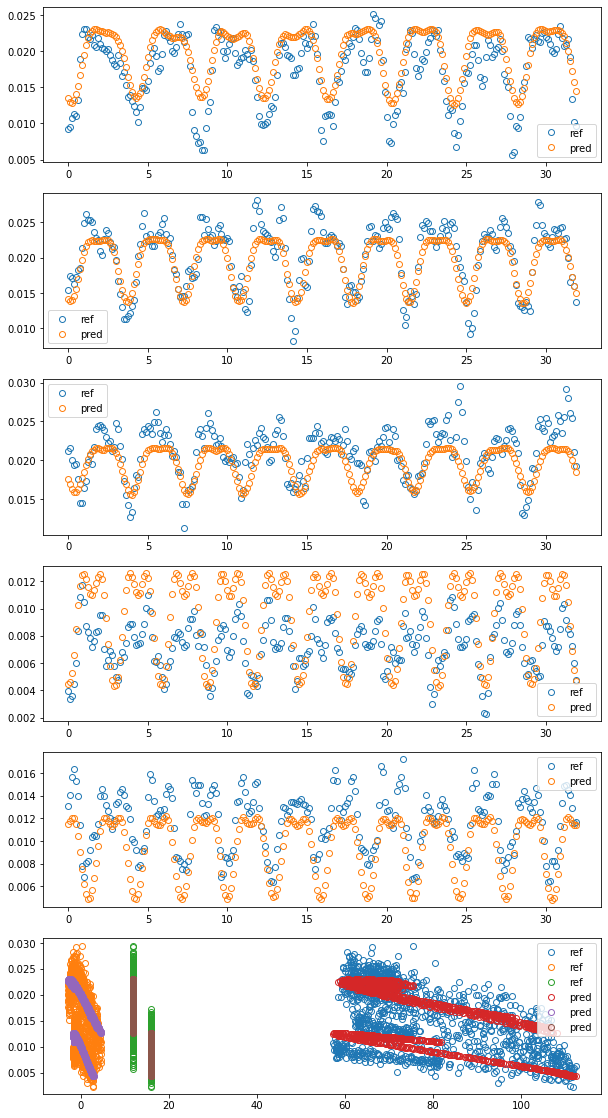

In [3]:
x_train = x_train_top[:, :3]
y_train = y_train_top[:, 2:3]

model_top = np.linalg.lstsq(np.hstack([x_train, np.ones((x_train.shape[0],1))]) ,  y_train)[0]
np.save("top_layer.linear.npy", model_top)


c = model_top[-1]
m = model_top[0:-1]
print(m, c)

y_ref = y_train.flatten()
y_pred_train = np.dot(x_train, m) + c

fig, ax = plt.subplots(n_exp + 1, figsize=(10,20))

ax[n_exp].plot(x_train, y_ref,  "o",  fillstyle = "none",  label="ref")
ax[n_exp].plot(x_train, y_pred_train,  "o",  fillstyle = "none",  label="pred")
ax[n_exp].legend()
    
for i in range(n_exp):
    ax[i].plot(yy, y_ref[i*nx:(i+1)*nx],         "o", fillstyle = "none", label="ref")
    ax[i].plot(yy, y_pred_train[i*nx:(i+1)*nx],  "o", fillstyle = "none", label="pred")
    ax[i].legend()

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


[[-3.31227385e-03]
 [ 5.47394603e-03]
 [ 5.28545691e-05]] [-0.14591772]


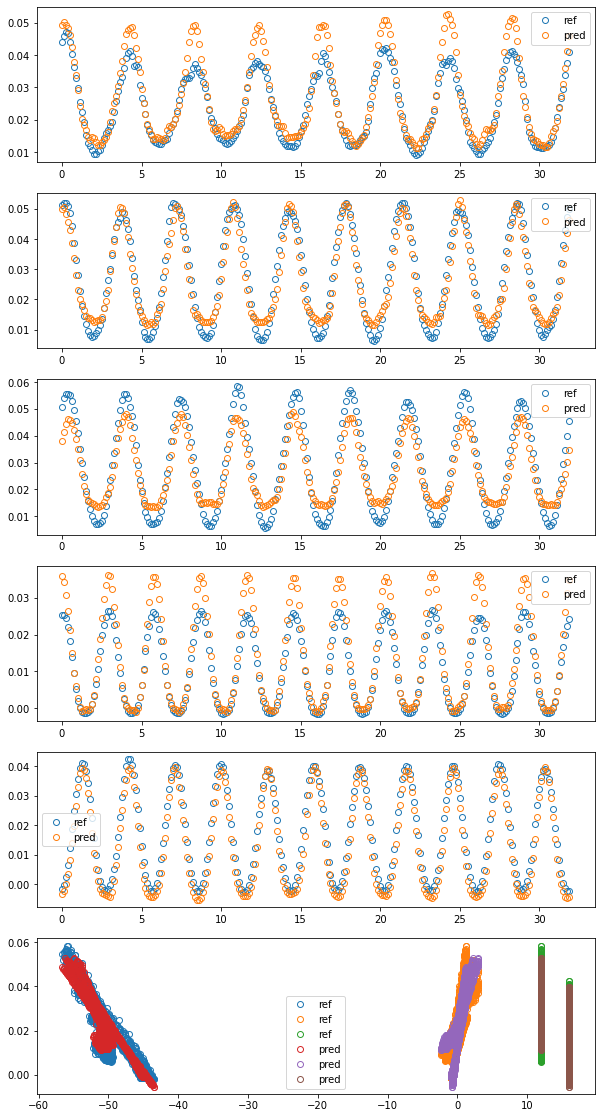

In [4]:
x_train = x_train_bot[:, :3]
y_train = y_train_bot[:, 2:3]

model_bot = np.linalg.lstsq(np.hstack([x_train, np.ones((x_train.shape[0],1))]) ,  y_train)[0]
np.save("bot_layer.linear.npy", model_bot)


c = model_bot[-1]
m = model_bot[0:-1]
print(m, c)

y_ref = y_train.flatten()
y_pred_train = np.dot(x_train, m) + c

fig, ax = plt.subplots(n_exp + 1,figsize=(10,20))

ax[n_exp].plot(x_train, y_ref,  "o",  fillstyle = "none",  label="ref")
ax[n_exp].plot(x_train, y_pred_train,  "o",  fillstyle = "none",  label="pred")
ax[n_exp].legend()
    
for i in range(n_exp):
    ax[i].plot(yy, y_ref[i*nx:(i+1)*nx],         "o", fillstyle = "none", label="ref")
    ax[i].plot(yy, y_pred_train[i*nx:(i+1)*nx],  "o", fillstyle = "none", label="pred")
    ax[i].legend()

# Test NN

In [5]:
from Utility import gradient_first
from Solver_q import *
import numpy as np
import scipy.io
import scipy.ndimage
import matplotlib.pyplot as plt
from timeit import default_timer

ny = 256
L = 32
yy, dy = np.linspace(0, L - L/ny, ny), L/ny

H = [1.0, 1.0]               # the rest depths of each layer
lam = 0.25
U = [1.0, -1.0]
dU = U[0] - U[1] 
F1 = 2.0/lam**2
F2 = 2.0/lam**2
hyper_nu, hyper_order = 0.0, 2

mu = 0.32        # bottom drag
file_name, beta  = 'beta12rek0p32', 12
start, end, step = 3000000, 6000000, 20000

flow_means, _ = preprocess_data(file_name, beta, lam, dU, L, start, end, step)
mu_mean, dpv_mean, u_mean, vor_mean, q_mean, psi_mean, flux_mean = flow_means[:7]


save_every = 1000
save_every = 1000
dt = 1e-3
Nt = 20000 #4000*10
Nt = 40000 #4000*10

# q0 = np.zeros((2, ny))
# q0[0, :] = 1e-1 * np.sin(2*np.pi*yy/L)
# q0[1, :] = 1e-1 * np.cos(2*np.pi*yy/L)

q0 = np.copy(q_mean)

    
y_sol, t_sol, q_sol = solve_q(ny, L, F1, F2, beta, mu, dU, hyper_nu, hyper_order, q0,
            dt, Nt, save_every,
            "linearmodel")

1000 max q 12.436573085152824
2000 max q 11.244275236329146
3000 max q 10.32704998002293
4000 max q 9.529583265033546
5000 max q 8.816599209622737
6000 max q 8.17491052282231
7000 max q 7.594549135409903
8000 max q 7.067576694450266
9000 max q 6.590593720149855
10000 max q 6.184222264141946
11000 max q 5.806922764140227
12000 max q 5.456181200826124
13000 max q 5.129746994720597
14000 max q 4.825602296993369
15000 max q 4.54193514233579
16000 max q 4.277115690319453
17000 max q 4.029675144189634
18000 max q 3.7982870781232476
19000 max q 3.581750953143113
20000 max q 3.3789776168018126
21000 max q 3.188976587583309
22000 max q 3.010844931257571
23000 max q 2.8437575458304867
24000 max q 2.6879388321950235
25000 max q 2.542722491987838
26000 max q 2.4059661616572376
27000 max q 2.2771771854230227
28000 max q 2.155890840210271
29000 max q 2.041668924483874
30000 max q 1.934098377297884
31000 max q 1.832789938664564
32000 max q 1.737376858294357
33000 max q 1.6475136568992301
34000 max q 

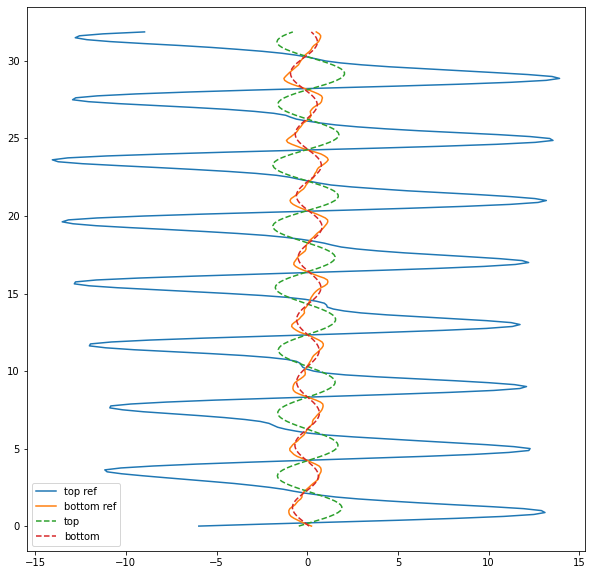

In [6]:
q_mean_ref = q_mean
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.plot(q_mean_ref[0, :], yy, label="top ref")
ax.plot(q_mean_ref[1, :], yy, label="bottom ref")

ax.plot(np.mean(q_sol[Nt//(2*save_every):, 0, :], axis=0), y_sol, "--", label="top")
ax.plot(np.mean(q_sol[Nt//(2*save_every):, 1, :], axis=0), y_sol, "--", label="bottom")

ax.legend()

# Train flux

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


[[ 0.00334431]
 [-0.0477161 ]
 [-0.18079327]] [3.35478018]


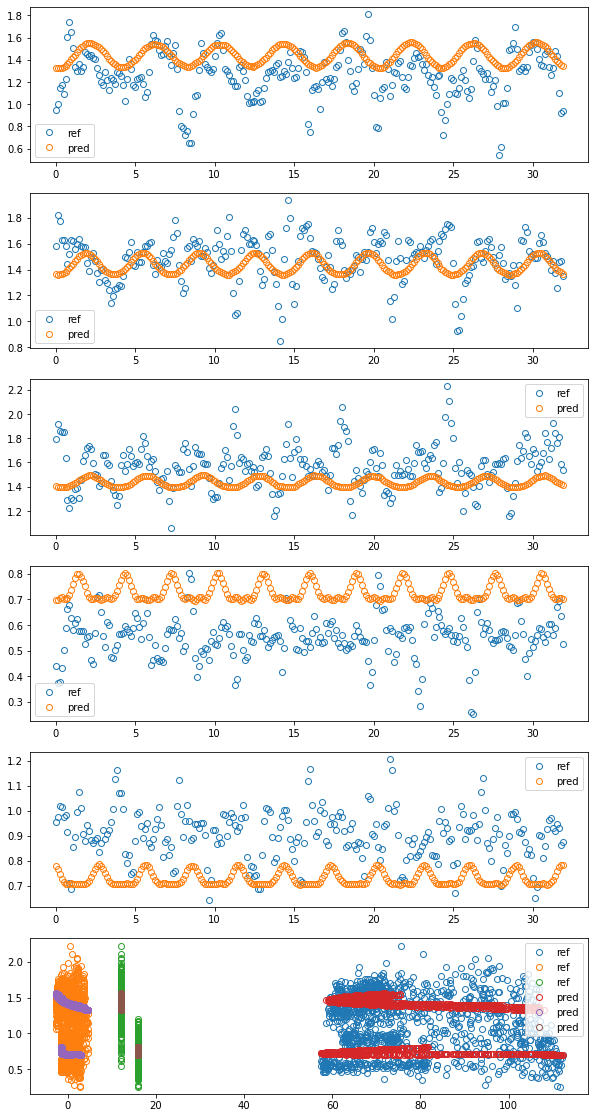

In [7]:
x_train = x_train_top[:, :3]
y_train = -y_train_top[:, 1:2]

model_top = np.linalg.lstsq(np.hstack([x_train, np.ones((x_train.shape[0],1))]) ,  y_train)[0]
np.save("top_layer_flux.linear.npy", model_top)


c = model_top[-1]
m = model_top[0:-1]
print(m, c)

y_ref = y_train.flatten()
y_pred_train = np.dot(x_train, m) + c

fig, ax = plt.subplots(n_exp + 1, figsize=(10,20))

ax[n_exp].plot(x_train, y_ref,  "o",  fillstyle = "none",  label="ref")
ax[n_exp].plot(x_train, y_pred_train,  "o",  fillstyle = "none",  label="pred")
ax[n_exp].legend()
    
for i in range(n_exp):
    ax[i].plot(yy, y_ref[i*nx:(i+1)*nx],         "o", fillstyle = "none", label="ref")
    ax[i].plot(yy, y_pred_train[i*nx:(i+1)*nx],  "o", fillstyle = "none", label="pred")
    ax[i].legend()

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


[[ 0.18046747]
 [-0.30279917]
 [-0.00088346]] [7.96730232]


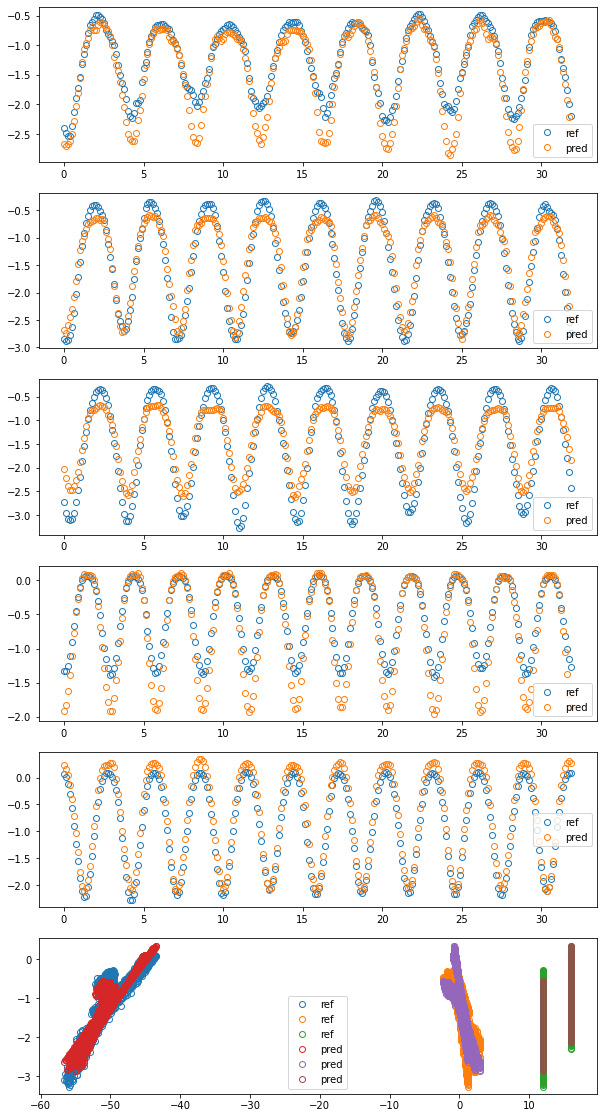

In [8]:
x_train = x_train_bot[:, :3]
y_train = -y_train_bot[:, 1:2]

model_bot = np.linalg.lstsq(np.hstack([x_train, np.ones((x_train.shape[0],1))]) ,  y_train)[0]
np.save("bot_layer_flux.linear.npy", model_bot)


c = model_bot[-1]
m = model_bot[0:-1]
print(m, c)

y_ref = y_train.flatten()
y_pred_train = np.dot(x_train, m) + c

fig, ax = plt.subplots(n_exp + 1,figsize=(10,20))

ax[n_exp].plot(x_train, y_ref,  "o",  fillstyle = "none",  label="ref")
ax[n_exp].plot(x_train, y_pred_train,  "o",  fillstyle = "none",  label="pred")
ax[n_exp].legend()
    
for i in range(n_exp):
    ax[i].plot(yy, y_ref[i*nx:(i+1)*nx],         "o", fillstyle = "none", label="ref")
    ax[i].plot(yy, y_pred_train[i*nx:(i+1)*nx],  "o", fillstyle = "none", label="pred")
    ax[i].legend()

In [9]:
from Utility import gradient_first
from Solver_q import *
import numpy as np
import scipy.io
import scipy.ndimage
import matplotlib.pyplot as plt
from timeit import default_timer

ny = 256
L = 32
yy, dy = np.linspace(0, L - L/ny, ny), L/ny

H = [1.0, 1.0]               # the rest depths of each layer
lam = 0.25
U = [1.0, -1.0]
dU = U[0] - U[1] 
F1 = 2.0/lam**2
F2 = 2.0/lam**2
hyper_nu, hyper_order = 0.0, 2

mu = 0.32        # bottom drag
file_name, beta  = 'beta12rek0p32', 12
start, end, step = 3000000, 6000000, 20000

flow_means, _ = preprocess_data(file_name, beta, lam, dU, L, start, end, step)
mu_mean, dpv_mean, u_mean, vor_mean, q_mean, psi_mean, flux_mean = flow_means[:7]


save_every = 1000
save_every = 1000
dt = 1e-3
Nt = 20000 #4000*10
Nt = 40000 #4000*10

# q0 = np.zeros((2, ny))
# q0[0, :] = 1e-1 * np.sin(2*np.pi*yy/L)
# q0[1, :] = 1e-1 * np.cos(2*np.pi*yy/L)

q0 = np.copy(q_mean)

    
y_sol, t_sol, q_sol = solve_q(ny, L, F1, F2, beta, mu, dU, hyper_nu, hyper_order, q0,
            dt, Nt, save_every,
            "linearfluxmodel")

1000 max q 13.37405919278433
2000 max q 12.890929202713949
3000 max q 12.44270918984433
4000 max q 12.020959687002756
5000 max q 11.621071250120027
6000 max q 11.240245025668454
7000 max q 10.876594946442573
8000 max q 10.52872425230524
9000 max q 10.195518341225155
10000 max q 9.901475167434272
11000 max q 9.619093616640997
12000 max q 9.346548805098829
13000 max q 9.083401924794762
14000 max q 8.829243803271492
15000 max q 8.58369032112079
16000 max q 8.346379380767273
17000 max q 8.116968722026012
18000 max q 7.895134228805609
19000 max q 7.680568541121487
20000 max q 7.472979871058438
21000 max q 7.272090964558895
22000 max q 7.077638173824771
23000 max q 6.889370617764252
24000 max q 6.707049415208526
25000 max q 6.53044698002551
26000 max q 6.359346370037908
27000 max q 6.193540683480599
28000 max q 6.032832497982877
29000 max q 5.877033347944868
30000 max q 5.7259632368245414
31000 max q 5.579450181338786
32000 max q 5.437329784960218
33000 max q 5.299444838392459
34000 max q 5.

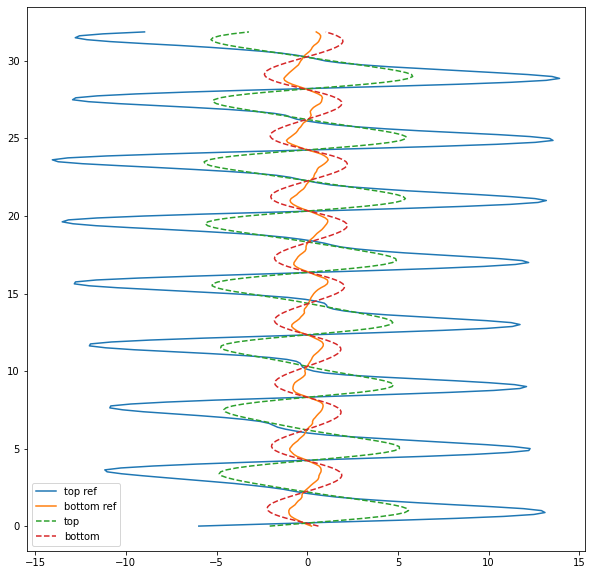

In [10]:
q_mean_ref = q_mean
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.plot(q_mean_ref[0, :], yy, label="top ref")
ax.plot(q_mean_ref[1, :], yy, label="bottom ref")

ax.plot(np.mean(q_sol[Nt//(2*save_every):, 0, :], axis=0), y_sol, "--", label="top")
ax.plot(np.mean(q_sol[Nt//(2*save_every):, 1, :], axis=0), y_sol, "--", label="bottom")

ax.legend()

# Top layer

The steady equation on the top layer with model term $M$ is 

$ \nabla M(dq/dy, u, \cdots)  = 0 $

converge to
$q = 0, u = 0 , \cdots$